In [1]:
import sys
sys.path.insert(0, "../..")

In [2]:
import torch
from torch import nn
from torch.utils import data
from torchvision import datasets, transforms
from tqdm.notebook import tqdm
from copy import deepcopy
from collections import deque

from extrapolation import *
from experiments import difference_matrix

In [2]:
torch.cuda.is_available()

True

In [3]:
train_ds = datasets.MNIST("../MNIST", download=True, train=True, transform=transforms.ToTensor())
test_ds = datasets.MNIST("../MNIST", download=True, train=False, transform=transforms.ToTensor())
valid_size = int(0.2 * len(train_ds))
train_ds, valid_ds = data.random_split(train_ds, [len(train_ds) - valid_size, valid_size])

train_loader = data.DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=2)
valid_loader = data.DataLoader(valid_ds, batch_size=64, shuffle=True, num_workers=2)
test_loader = data.DataLoader(test_ds, batch_size=64, shuffle=False, num_workers=2)

In [9]:
model = nn.Sequential(
    nn.Conv2d(1, 32, 3),
    nn.ReLU(),
    nn.Conv2d(32, 32, 3),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(32, 64, 3),
    nn.ReLU(),
    nn.Conv2d(64, 64, 3),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(4*4*64, 128),
    nn.ReLU(),
    nn.Linear(128, 10),
    nn.LogSoftmax(-1),
)
model.cuda()

Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (3): ReLU()
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (6): ReLU()
  (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (8): ReLU()
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Flatten(start_dim=1, end_dim=-1)
  (11): Linear(in_features=1024, out_features=128, bias=True)
  (12): ReLU()
  (13): Linear(in_features=128, out_features=10, bias=True)
  (14): LogSoftmax(dim=-1)
)

In [10]:
val_loss_fn = nn.NLLLoss(reduction="sum")

def validation(model, loader):
    ok = 0
    loss_sum = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for x, y in tqdm(loader):
            x = x.cuda()
            y = y.cuda()
            out = model(x)
            loss_sum += val_loss_fn(out, y)
            preds = out.argmax(1)
            ok += (y == preds).sum()
            total += len(y)
    return ok / total, loss_sum / total

def train_epoch(loss_log):
    model.train()
    for x, y in tqdm(train_loader):
        x = x.cuda()
        y = y.cuda()
        optimizer.zero_grad()
        out = model(x)
        loss = loss_fn(out, y)
        loss.backward()
        loss_log.append(loss.item())
        optimizer.step()

In [11]:
validation(model, valid_loader)

(tensor(0.0879, device='cuda:0'), tensor(2.3040, device='cuda:0'))

## Without acceleration

In [12]:
initial_state = deepcopy(model.state_dict())
optimizer = torch.optim.SGD(model.parameters(), 3e-3)
loss_fn = nn.NLLLoss()

In [13]:
epochs = 40
without_acc = {"train_loss": [], "val_loss": [], "val_acc": []}

for epoch in range(epochs):
    print("Epoch", epoch+1)
    train_epoch(without_acc["train_loss"])
    val_acc, val_loss = validation(model, valid_loader)
    without_acc["val_loss"].append(val_loss)
    without_acc["val_acc"].append(val_acc)
    print(f"Validation accuracy: {val_acc:.4f}, validation loss: {val_loss:.4f}")

Epoch 1



Validation accuracy: 0.1243, validation loss: 2.2984
Epoch 2



Validation accuracy: 0.4216, validation loss: 2.2853
Epoch 3



Validation accuracy: 0.6682, validation loss: 1.8084
Epoch 4



Validation accuracy: 0.8587, validation loss: 0.4596
Epoch 5



Validation accuracy: 0.9147, validation loss: 0.2912
Epoch 6



Validation accuracy: 0.9252, validation loss: 0.2394
Epoch 7



Validation accuracy: 0.9459, validation loss: 0.1746
Epoch 8



Validation accuracy: 0.9524, validation loss: 0.1532
Epoch 9



Validation accuracy: 0.9593, validation loss: 0.1334
Epoch 10



Validation accuracy: 0.9668, validation loss: 0.1113
Epoch 11



Validation accuracy: 0.9651, validation loss: 0.1098
Epoch 12



Validation accuracy: 0.9687, validation loss: 0.1024
Epoch 13



Validation accuracy: 0.9701, validation loss: 0.0934
Epoch 14



Validation accuracy: 0.9725, validation loss: 0.0869
Epoch 15



Validation accuracy: 0.9692, validation loss: 0.0952
Epoch 16



Validation accuracy: 0.9750, validation loss: 0.0820
Epoch 17



Validation accuracy: 0.9780, validation loss: 0.0725
Epoch 18



Validation accuracy: 0.9710, validation loss: 0.0896
Epoch 19



Validation accuracy: 0.9797, validation loss: 0.0656
Epoch 20



Validation accuracy: 0.9794, validation loss: 0.0661
Epoch 21



Validation accuracy: 0.9796, validation loss: 0.0644
Epoch 22



Validation accuracy: 0.9779, validation loss: 0.0721
Epoch 23



Validation accuracy: 0.9797, validation loss: 0.0624
Epoch 24



Validation accuracy: 0.9804, validation loss: 0.0619
Epoch 25



Validation accuracy: 0.9818, validation loss: 0.0619
Epoch 26



Validation accuracy: 0.9818, validation loss: 0.0601
Epoch 27



Validation accuracy: 0.9832, validation loss: 0.0555
Epoch 28



Validation accuracy: 0.9824, validation loss: 0.0570
Epoch 29



Validation accuracy: 0.9827, validation loss: 0.0557
Epoch 30



Validation accuracy: 0.9801, validation loss: 0.0645
Epoch 31



Validation accuracy: 0.9834, validation loss: 0.0535
Epoch 32



Validation accuracy: 0.9831, validation loss: 0.0563
Epoch 33



Validation accuracy: 0.9836, validation loss: 0.0525
Epoch 34



Validation accuracy: 0.9846, validation loss: 0.0520
Epoch 35



Validation accuracy: 0.9831, validation loss: 0.0543
Epoch 36



Validation accuracy: 0.9834, validation loss: 0.0557
Epoch 37



Validation accuracy: 0.9854, validation loss: 0.0490
Epoch 38



Validation accuracy: 0.9848, validation loss: 0.0529
Epoch 39



Validation accuracy: 0.9823, validation loss: 0.0588
Epoch 40



Validation accuracy: 0.9854, validation loss: 0.0496


In [14]:
final_without_acc = deepcopy(model.state_dict())

## With acceleration, online scheme

In [15]:
def params_to_vector(parameters):
    param_vectors = []
    for param in parameters:
        param_vectors.append(param.data.flatten().cpu())
    return torch.hstack(param_vectors)

def params_from_vector(parameters, x):
    idx = 0
    for param in parameters:
        n = param.data.numel()
        param.data[:] = x[idx:idx+n].view(param.data.shape)
        idx += n

In [16]:
model.load_state_dict(initial_state)
optimizer = torch.optim.SGD(model.parameters(), 3e-3)

In [17]:
epochs = 40
k = 10
with_acc = {"train_loss": [], "val_loss": [], "val_acc": []}
model_hist = deque(maxlen=k+1)

for epoch in range(epochs):
    print("Epoch", epoch+1)
    train_epoch(with_acc["train_loss"])

    x = params_to_vector(model.parameters())
    model_hist.append(x)
    if len(model_hist) == k + 1:
        U = difference_matrix(list(model_hist))
        y = regularized_RRE(torch.vstack(list(model_hist)[1:]), U, 1e-5)
        params_from_vector(model.parameters(), y)
    
    val_acc, val_loss = validation(model, valid_loader)
    with_acc["val_loss"].append(val_loss)
    with_acc["val_acc"].append(val_acc)
    print(f"Validation accuracy: {val_acc:.4f}, validation loss: {val_loss:.4f}")

Epoch 1



Validation accuracy: 0.1243, validation loss: 2.2984
Epoch 2



Validation accuracy: 0.4070, validation loss: 2.2853
Epoch 3



Validation accuracy: 0.6538, validation loss: 1.8093
Epoch 4



Validation accuracy: 0.8745, validation loss: 0.4205
Epoch 5



Validation accuracy: 0.9138, validation loss: 0.2919
Epoch 6



Validation accuracy: 0.9308, validation loss: 0.2246
Epoch 7



Validation accuracy: 0.9443, validation loss: 0.1842
Epoch 8



Validation accuracy: 0.9452, validation loss: 0.1778
Epoch 9



Validation accuracy: 0.9588, validation loss: 0.1303
Epoch 10



Validation accuracy: 0.9660, validation loss: 0.1163
Epoch 11



Validation accuracy: 0.7949, validation loss: 2.0371
Epoch 12



Validation accuracy: 0.9523, validation loss: 0.1550
Epoch 13



Validation accuracy: 0.9561, validation loss: 0.1392
Epoch 14



Validation accuracy: 0.9567, validation loss: 0.1375
Epoch 15



Validation accuracy: 0.9592, validation loss: 0.1296
Epoch 16



Validation accuracy: 0.9620, validation loss: 0.1228
Epoch 17



Validation accuracy: 0.9636, validation loss: 0.1183
Epoch 18



Validation accuracy: 0.9647, validation loss: 0.1150
Epoch 19



Validation accuracy: 0.9659, validation loss: 0.1117
Epoch 20



Validation accuracy: 0.9667, validation loss: 0.1105
Epoch 21



Validation accuracy: 0.9669, validation loss: 0.1090
Epoch 22



Validation accuracy: 0.9698, validation loss: 0.0991
Epoch 23



Validation accuracy: 0.9690, validation loss: 0.1022
Epoch 24



Validation accuracy: 0.9704, validation loss: 0.0986
Epoch 25



Validation accuracy: 0.9710, validation loss: 0.0959
Epoch 26



Validation accuracy: 0.9714, validation loss: 0.0941
Epoch 27



Validation accuracy: 0.9717, validation loss: 0.0933
Epoch 28



Validation accuracy: 0.9726, validation loss: 0.0913
Epoch 29



Validation accuracy: 0.9729, validation loss: 0.0896
Epoch 30



Validation accuracy: 0.9726, validation loss: 0.0888
Epoch 31



Validation accuracy: 0.9728, validation loss: 0.0873
Epoch 32



Validation accuracy: 0.9732, validation loss: 0.0871
Epoch 33



Validation accuracy: 0.9732, validation loss: 0.0875
Epoch 34



Validation accuracy: 0.9752, validation loss: 0.0818
Epoch 35



Validation accuracy: 0.9732, validation loss: 0.0841
Epoch 36



Validation accuracy: 0.9749, validation loss: 0.0815
Epoch 37



Validation accuracy: 0.9751, validation loss: 0.0803
Epoch 38



Validation accuracy: 0.9749, validation loss: 0.0798
Epoch 39



Validation accuracy: 0.9753, validation loss: 0.0787
Epoch 40



Validation accuracy: 0.9755, validation loss: 0.0779


## With acceleration, offline scheme

In [ ]:
model.load_state_dict(initial_state)
optimizer = torch.optim.SGD(model.parameters(), 3e-3)

In [19]:
epochs = 40
k = 10
with_acc_offline = {"train_loss": [], "val_loss": [], "val_acc": []}
model_hist = deque(maxlen=k+1)

for epoch in range(epochs):
    print("Epoch", epoch+1)
    train_epoch(with_acc_offline["train_loss"])
    
    model_acc = None
    x = params_to_vector(model.parameters())
    model_hist.append(x)
    if len(model_hist) == k + 1:
        U = difference_matrix(list(model_hist))
        y = regularized_RRE(torch.vstack(list(model_hist)[1:]), U, 1e-5)
        model_acc = deepcopy(model)
        params_from_vector(model.parameters(), y)
        
    if model_acc is None:
        val_acc, val_loss = validation(model, valid_loader)
    else:
        val_acc, val_loss = validation(model_acc, valid_loader)
    with_acc_offline["val_loss"].append(val_loss)
    with_acc_offline["val_acc"].append(val_acc)
    print(f"Validation accuracy: {val_acc:.4f}, validation loss: {val_loss:.4f}")

Epoch 1



Validation accuracy: 0.1243, validation loss: 2.2984
Epoch 2



Validation accuracy: 0.4021, validation loss: 2.2853
Epoch 3



Validation accuracy: 0.6338, validation loss: 1.8154
Epoch 4



Validation accuracy: 0.8790, validation loss: 0.4097
Epoch 5



Validation accuracy: 0.9082, validation loss: 0.3013
Epoch 6



Validation accuracy: 0.9282, validation loss: 0.2343
Epoch 7



Validation accuracy: 0.9447, validation loss: 0.1824
Epoch 8



Validation accuracy: 0.9492, validation loss: 0.1616
Epoch 9



Validation accuracy: 0.9623, validation loss: 0.1249
Epoch 10



Validation accuracy: 0.9638, validation loss: 0.1145
Epoch 11



Validation accuracy: 0.7950, validation loss: 2.0746
Epoch 12



Validation accuracy: 0.9688, validation loss: 0.1104
Epoch 13



Validation accuracy: 0.9733, validation loss: 0.0877
Epoch 14



Validation accuracy: 0.9737, validation loss: 0.0844
Epoch 15



Validation accuracy: 0.9748, validation loss: 0.0804
Epoch 16



Validation accuracy: 0.9759, validation loss: 0.0774
Epoch 17



Validation accuracy: 0.9765, validation loss: 0.0760
Epoch 18



Validation accuracy: 0.9769, validation loss: 0.0723
Epoch 19



Validation accuracy: 0.9784, validation loss: 0.0670
Epoch 20



Validation accuracy: 0.9812, validation loss: 0.0614
Epoch 21



Validation accuracy: 0.9816, validation loss: 0.0599
Epoch 22



Validation accuracy: 0.9824, validation loss: 0.0586
Epoch 23



Validation accuracy: 0.9832, validation loss: 0.0578
Epoch 24



Validation accuracy: 0.9828, validation loss: 0.0576
Epoch 25



Validation accuracy: 0.9824, validation loss: 0.0579
Epoch 26



Validation accuracy: 0.9830, validation loss: 0.0569
Epoch 27



Validation accuracy: 0.9826, validation loss: 0.0566
Epoch 28



Validation accuracy: 0.9832, validation loss: 0.0554
Epoch 29



Validation accuracy: 0.9837, validation loss: 0.0550
Epoch 30



Validation accuracy: 0.9848, validation loss: 0.0537
Epoch 31



Validation accuracy: 0.9850, validation loss: 0.0535
Epoch 32



Validation accuracy: 0.9847, validation loss: 0.0526
Epoch 33



Validation accuracy: 0.9849, validation loss: 0.0515
Epoch 34



Validation accuracy: 0.9852, validation loss: 0.0505
Epoch 35



Validation accuracy: 0.9858, validation loss: 0.0494
Epoch 36



Validation accuracy: 0.9857, validation loss: 0.0488
Epoch 37



Validation accuracy: 0.9857, validation loss: 0.0478
Epoch 38



Validation accuracy: 0.9861, validation loss: 0.0469
Epoch 39



Validation accuracy: 0.9862, validation loss: 0.0464
Epoch 40



Validation accuracy: 0.9857, validation loss: 0.0461


In [20]:
results = {
    "without_acc": without_acc,
    "with_acc_online": with_acc,
    "with_acc_offline": with_acc_offline,
}
torch.save(results, "first_nn_results_10.p")

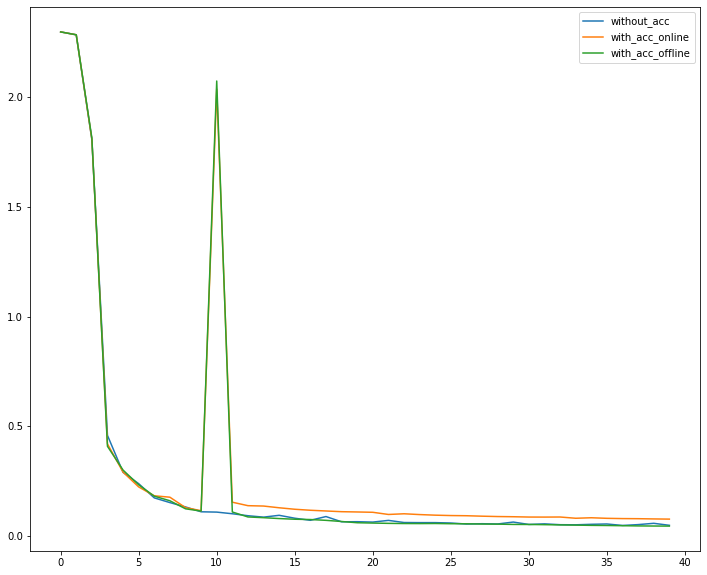

In [21]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 10))
x = np.arange(40)
for name, res in results.items():
    plt.plot(x, res["val_loss"], label=name)
plt.legend()

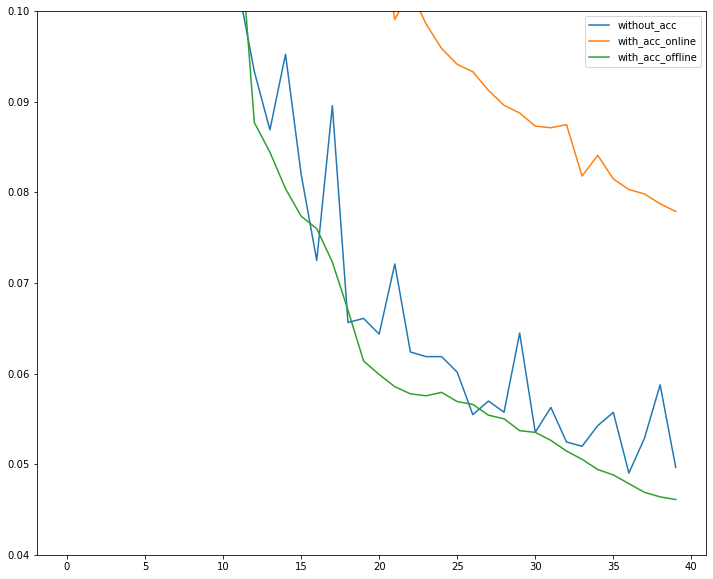

In [22]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 10))
x = np.arange(40)
for name, res in results.items():
    plt.plot(x, res["val_loss"], label=name)
plt.ylim(0.04, 0.1)
plt.legend()